In [2]:
import os
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import re

from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add


import gensim.downloader
embed = gensim.downloader.load("glove-wiki-gigaword-100")

In [5]:
path = os.getcwd()
os.chdir('Data')
base_diresctory = os.getcwd()

In [ ]:
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
print(model.summary())

553467096/553467096 [==============================] - 5s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
def method1(path, img_name):
    # load the image from file
    image = load_img(path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]

    # plt.imshow(image[0, ..., 0])
    # plt.axis('off')  # Turn off the axis
    # plt.title(image_id)
    # plt.show()
    # store feature
    return image_id, feature

In [ ]:
def method2(path, img_name):
    target_height = 224
    target_width = 224
    # Load and preprocess image
    image = tf.io.read_file(path)
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)

    # Calculate the aspect ratio of the original image
    original_height, original_width, _ = tf.unstack(tf.shape(image))
    aspect_ratio = tf.cast(original_width, tf.float32) / tf.cast(original_height, tf.float32)

    # Calculate the new dimensions while preserving the aspect ratio
    if aspect_ratio > 1.0:
        new_width = target_width
        new_height = tf.cast(target_width / aspect_ratio, tf.int32)
    else:
        new_height = target_height
        new_width = tf.cast(target_height * aspect_ratio, tf.int32)

    # Resize and pad the image to the target size
    resized_image = tf.image.resize_with_pad(image, target_height, target_width, method='bilinear')
    resized_image = tf.image.convert_image_dtype(resized_image, tf.uint8)
    resized_image = tf.expand_dims(resized_image, 0)

    image_id = img_name.split('.')[0]

    # plt.imshow(resized_image[0, ..., 0])
    # plt.axis('off')
    # plt.title(image_id)
    # plt.show()

    feature = model.predict(resized_image, verbose=0)
    return image_id, feature

In [ ]:
img_features = {}
working_directory = base_directory + '/images'

target_height = 224
target_width = 224
count = 0

for img_name in os.listdir(working_directory):
    if img_name.endswith('.jpg'):
        path = working_directory + '/' + img_name

        imid, fe = method1(path, img_name)
        # imid, fe = method2(path, img_name)
        img_features[imid] = fe
        count += 1
        if count % 100 == 0:
            print(count)


In [ ]:
# saving the features because processing the data takes a while
pickle.dump(img_features, open(os.path.join(base_directory, 'features2.pkl'), 'wb'))

In [ ]:
with open(os.path.join(base_directory, 'features2.pkl'), 'rb') as f:
    img_features = pickle.load(f)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
filename = base_directory + '/descriptions.csv'
captions = pd.read_csv(filename)
captions['file'] = captions['file'].str[:-4]
captions = captions[captions['file'] != 'a6a35734-ee74-42bd-a13a-dfa2b683fcda'] # outlier in length


In [ ]:
def clean_caption(caption):
    # Convert to lowercase
    caption = caption.lower()
    # Remove special characters and punctuation using regular expressions
    caption = re.sub(r'[^a-zA-Z\s]', '', caption)
    caption = ' '.join(caption.split())
    caption = 'startseq ' + caption + ' endseq'
    return caption

captions['description'] = captions['description'].apply(clean_caption)

# Create a dictionary to map labels to tokenized captions
mappings = {}

for index, row in captions.iterrows():
    label = row['file']
    tokens = row['description']
    mappings[label] = tokens
print(mappings['2d33d6a3-d2eb-496d-9ac6-832911e178f1'])


startseq the student filled in two given sets of double number lines in the first double number line the student completed the top number line with frac frac frac frac frac note that was prefilled in the diagram the student completed the bottom line with in the second double number line the student completed the top number line with the student completed the bottom number line with endseq


In [ ]:
# Initialize the tokenizer
tokenizer = Tokenizer(oov_token='UNK')
tokenizer.fit_on_texts(captions['description'])
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
print("Vocab size: ", vocab_size)
max_length = max(len(caption.split()) for caption in captions['description'])
print("Max lenght: ", max_length)
max_length = 30

Vocab size:  1690
Max lenght:  180


In [ ]:
# creating train-validation-test split
image_ids = list(mappings.keys())
train, test = train_test_split(image_ids, test_size=0.1)
# train, val = train_test_split(train, test_size=0.01)


In [ ]:
def data_generator(data_keys, mapping, features, tokenizer, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            caption = mapping[key]
            # encode the sequence
            seq = tokenizer.texts_to_sequences([caption])[0]
            # split the sequence into X, y pairs
            for i in range(1, len(seq)):
                # split into input and output pairs
                in_seq, out_seq = seq[:i], seq[i]
                # pad input sequence
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                # encode output sequence
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                # store the sequences
                X1.append(features[key][0])
                X2.append(in_seq)
                y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0


In [ ]:
# Hyperparameters
lr = 0.000005
dropout = 0.25


In [ ]:
embedding_matrix = np.zeros((vocab_size, embed.vectors.shape[1]))
for word, i in tokenizer.word_index.items():
    if word in embed:
        embedding_matrix[i] = embed[word]
print(embedding_matrix.shape)

(1690, 100)


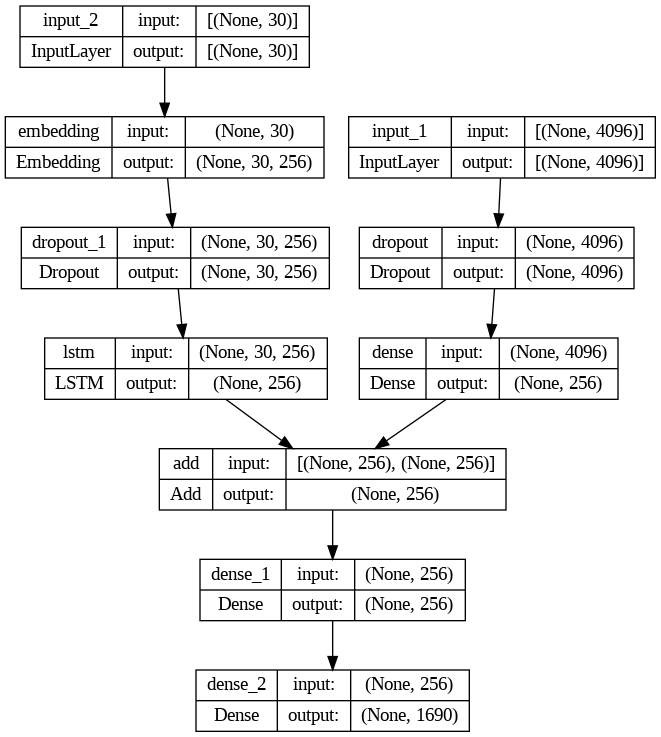

In [ ]:
# Create the model
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
# Use GloVe embeddings for the embedding layer
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(dropout)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)

opt = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)


In [ ]:
def train_model():
    epochs = 5
    batch_size = 32
    steps = len(train) // batch_size

    for i in range(epochs):
        # create data generator
        train_gen = data_generator(train, mappings, img_features, tokenizer, batch_size)
        # val_gen = data_generator(val, mappings, img_features, tokenizer, batch_size)
        # fit for one epoch
        model.fit(train_gen, epochs=1, steps_per_epoch=steps, verbose=1)
        print("Epoch ", i)

In [ ]:
train_model()

In [ ]:
model.save(base_directory + '/best_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# if I want to load a previous model
model = load_model(base_directory + '/best_model.h5')

In [ ]:
# helper to generate captions
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        oov_ind = np.argmax(yhat)
        yhat[0, oov_ind] = 0
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        if word == 'UNK':
          continue
        # stop if word not found
        if word == None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break

    return in_text

In [ ]:
# if debugging
test = test[:50]

In [ ]:
# validate with test data
actual, predicted = list(), list()

count = 0
for key in test:
    count += 1
    if count % 10 == 0:
      print(count)
    # get actual caption
    caption = mappings[key]
    # predict the caption for image
    y_pred = predict_caption(model, img_features[key], tokenizer, max_length)
    # split into words
    actual_caption = caption.split()
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_caption)
    predicted.append(y_pred)


In [ ]:
from nltk.translate.bleu_score import corpus_bleu

# Print the average BLEU-1 score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))

In [ ]:
from PIL import Image

def generate_caption(image_name):
    # load the image
    image_id = image_name.split('.')[0]
    img_path = os.path.join(base_directory, "images", image_name)
    image = Image.open(img_path)
    caption = mappings[image_id]
    print('---------------------Actual---------------------')
    print(caption)
    # predict the caption
    y_pred = predict_caption(model, img_features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq by figure c is written bottom top front face back face side other side sa u by figure d is top bottom side other side by figure e is written front face back face with arrows sa u and u with an arrow pointing at both and it is circled endseq
--------------------Predicted--------------------
startseq is circled out to the other triangle on top other a parallelogram that the parallelogram with the bottom side


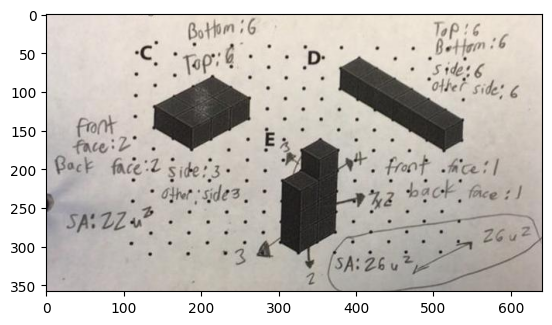

In [ ]:
generate_caption('fdf4a4cb-7ba9-4e78-bade-d83014f04727.jpg')